In [1]:
import psycopg2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
user="postgres"
password="asdasd"
database="annp_final"

In [3]:
def make_query(host, database, user, password, query):

    conn = psycopg2.connect(
        host=host,
        database=database,
        user=user,
        password=password
    )

    cur = conn.cursor()
    cur.execute(query)

    results = cur.fetchall()
    cols = [desc[0] for desc in cur.description]

    conn.close()

    return results, cols



In [ ]:
query = '''
SELECT 
	COUNT(nation) count_nation,
	nation
FROM annp_final.athlete
GROUP BY nation 
ORDER BY count_nation DESC;
'''

In [ ]:
res, cols = make_query(host="localhost", database=database, user=user, password=password, query=query)

In [ ]:
xx = list()
yy = list()

for i in range(len(res)):
    xx.append(res[i][0])
    yy.append(res[i][1])
plt.bar(x=yy, height=xx)
plt.show()

In [ ]:
query = '''
SELECT 
	COUNT(gender) count_gender,
	gender
FROM db_annp.athlete
GROUP BY gender 
ORDER BY count_gender DESC;
'''

In [ ]:
res, cols = make_query(host="localhost", database="postgres", user="postgres", password="asdasd", query=query)

In [ ]:
xx = list()
yy = list()

for i in range(len(res)):
    xx.append(res[i][0])
    yy.append(res[i][1])
plt.bar(x=yy, height=xx)
plt.show()

In [ ]:
query = '''
    SELECT 
        nation,
        gender,
        count(*)
    FROM db_annp.athlete
    GROUP BY CUBE (nation, gender)
    ORDER BY nation, gender NULLS LAST;
'''

In [ ]:
res, cols = make_query(host="localhost", database="postgres", user="postgres", password="asdasd", query=query)

In [ ]:
def get_info_for_bars(res):

    countries = []
    gender = []
    for el in res:
        if el[0] not in countries and el[0] is not None:
            countries.append(el[0])
        elif el[1] not in gender and el[1] is not None:
            gender.append(el[1])
        else:
                pass

    nat_gen = [(c, g) for c in countries for g in gender]

    resn = []
    for el in res:
        if el[0] is None or el[1] is None:
            pass
        else:
            resn.append((el[0], el[1]))
    
    diff = list(set(nat_gen) - set(resn))
    
    for i in range(len(diff)):
        diff[i] = diff[i] + (0,)
    
    res_f = []
    for el in res:
        if el[0] is None or el[1] is None:
            pass
        else:
            res_f.append((el[0], el[1], el[2]))
    
    res_f = (res_f + diff)
    res_f.sort()
    count_female = []
    count_male = []

    for row in res_f:
        if row[1] == "F":
            count_female.append(row[2])
        elif row[1] == "M":
            count_male.append(row[2])
        else:
            pass
        
    return countries, count_male, count_female

In [ ]:
countries, count_male, count_female = get_info_for_bars(res)

In [ ]:
count_male
count_female
countries

x = np.arange(len(countries))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(dpi=150)
rects1 = ax.bar(x - width/2, count_male, width, label='Men')
rects2 = ax.bar(x + width/2, count_female, width, label='Women')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Participans')
ax.set_title('Participants by country and gender')
ax.set_xticks(x, countries)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

# Club de facto

In [18]:
query = '''
SELECT 
    CASE GROUPING(cd.meetid)
        WHEN 1 THEN 'all_meets'
        ELSE cd.meetid
    END AS "Tournament",
    CASE GROUPING(c.code)
        WHEN 1 THEN 'all_clubs'
        ELSE c.code
    END AS "Team",
       ROUND(AVG(average_age), 0) AS "Average Age",
       ROUND(AVG(average_swimtime), 2) AS "Average Swimtime",
       ROUND(SUM(total_points)) AS "Total Points",
       ROUND(SUM(number_of_players)) AS "Total Players"
FROM (
    SELECT CAST(meetid AS VARCHAR(255)),
           clubid,
           average_age,
           total_points,
           average_swimtime,
           number_of_players
        FROM annp_final.club_defacto) cd
JOIN annp_final.club c ON c.clubid = cd.clubid
GROUP BY CUBE (cd.meetid, c.code);
'''

In [19]:
res, cols = make_query(host="localhost", database=database, user=user, password=password, query=query)

In [20]:
results = {}
for i in range(len(cols)):
    col = cols[i]
    results[col] = list(map(lambda x: x[i], res))

In [21]:
df = pd.DataFrame(results)

In [22]:
df.head()

,Tournament,Team,Average Age,Average Swimtime,Total Points,Total Players
0,all_meets,all_clubs,45,30.80,400835,999
1,41231235,LPS,43,27.20,22106,56
2,41231234,ADP,35,23.33,4191,13
3,41231235,CAPGE,31,32.01,4260,12
4,41231234,CGA,42,11.58,1956,3


In [23]:
df_p = df.pivot_table(
    values=['Average Age', 'Average Swimtime', 'Total Points', 'Total Players'],
    index='Team',
    columns='Tournament',
    aggfunc=np.mean,
    fill_value=0
)
df_p.drop(index='all_clubs', inplace=True)

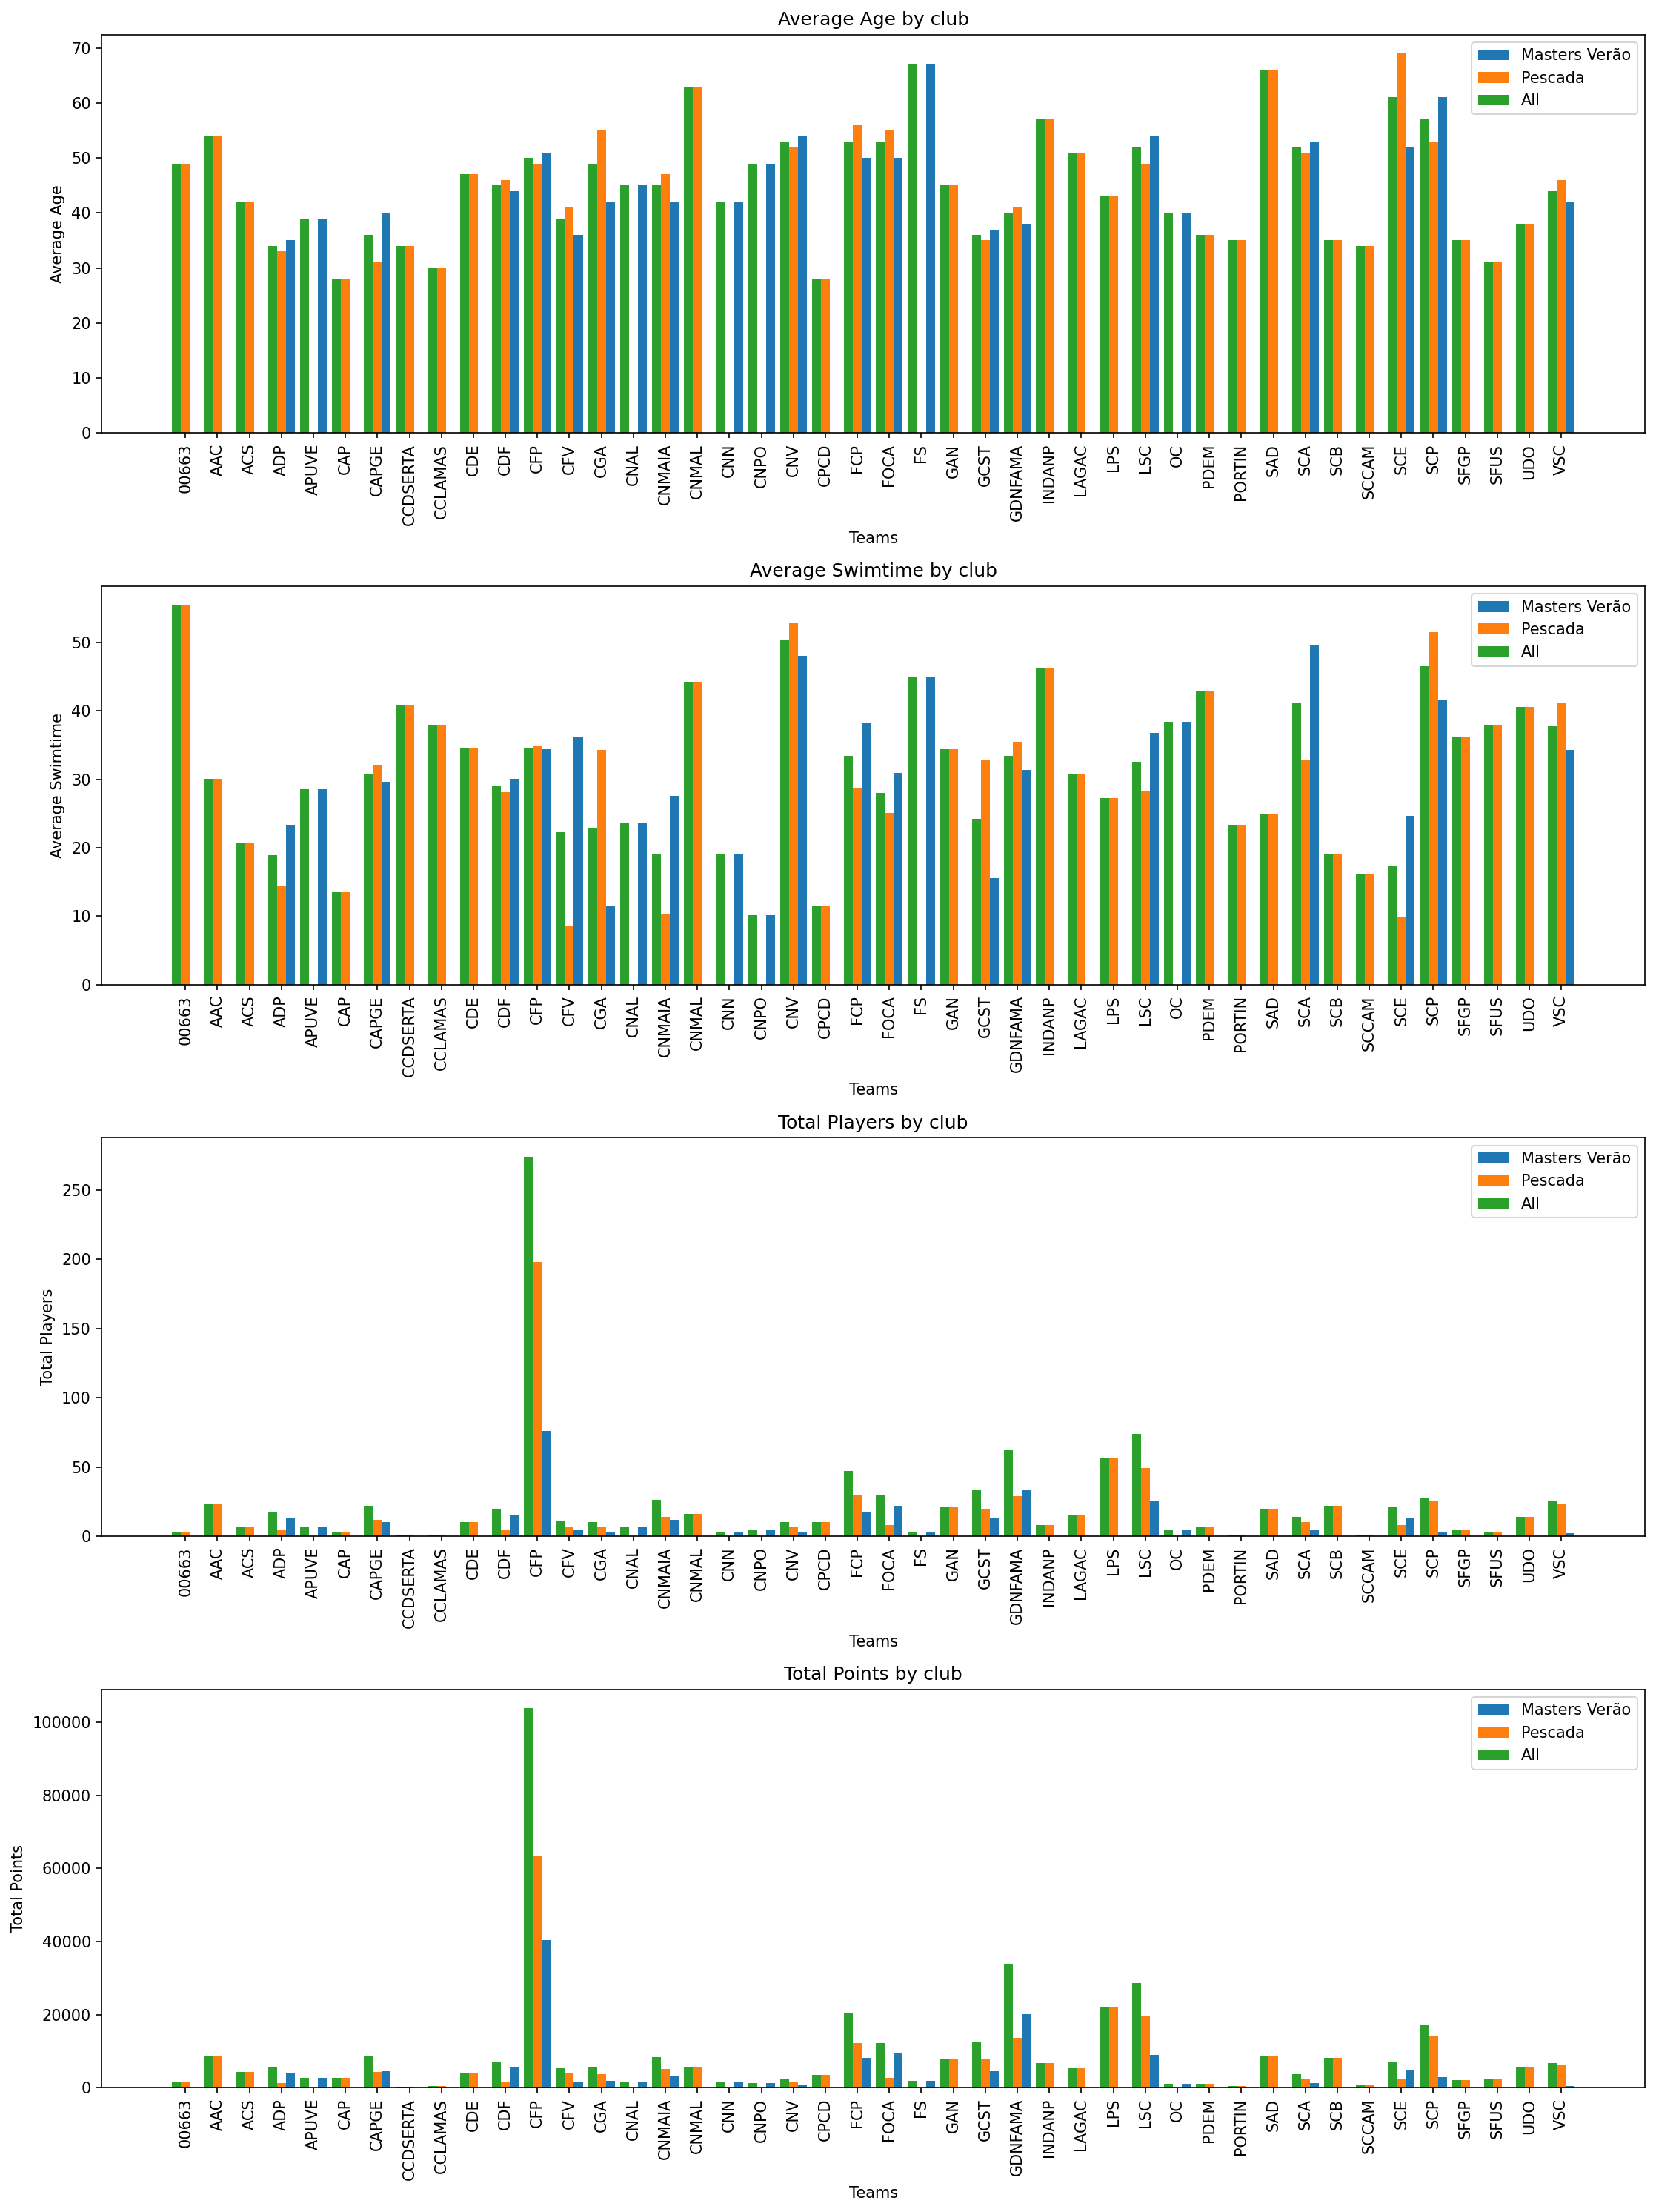

In [28]:
cols = list(df_p.columns.levels[0])
idx = df_p.index
x = np.arange(len(np.array(idx)))
clubs = np.array(df_p.index)


width = 0.28  #the width of the bars

fig, ax = plt.subplots(len(cols), figsize=(15,20), dpi=150)
ax.ravel()

for i in range(len(cols)):
    col = cols[i]

    col_1 = df_p[cols[i]].reset_index().iloc[:, 1].values
    col_2 = df_p[cols[i]].reset_index().iloc[:, 2].values
    col_3 = df_p[cols[i]].reset_index().iloc[:, 3].values

    ax[i].bar(x + width , col_1, width, label='Masters Verão')
    ax[i].bar(x, col_2, width, label='Pescada')
    ax[i].bar(x - width, col_3, width, label='All')

    ax[i].set_xticks(x, clubs, rotation=90)
    
    ax[i].set_xlabel('Teams')
    ax[i].set_ylabel("{colname}".format(colname=col))
    ax[i].set_title("{colname} by club".format(colname=col))
    ax[i].legend()
plt.tight_layout()
plt.show()



# Athlete de facto

In [43]:
query = '''
SELECT
    CASE GROUPING(a.firstname)
        WHEN 1 THEN 'all_players'
        ELSE a.firstname
    END AS "Athletes",
    CASE GROUPING(af.meetid)
        WHEN 1 THEN 'all_meets'
        ELSE af.meetid
    END AS "Tournament",
    ROUND(AVG(average_points), 2) AS "Average Points",
    ROUND(AVG(average_distance), 2) AS "Average Distance",
    ROUND(AVG(average_swimtime), 2) AS "Average Swimtime"
FROM (
    SELECT
        athleteid,
        CAST(meetid as VARCHAR(255)),
        average_points,
        average_distance,
        average_swimtime
    FROM annp_final.athlete_defacto) af
JOIN annp_final.athlete a ON a.athleteid = af.athleteid
GROUP BY CUBE (a.firstname, af.meetid)
ORDER BY "Average Points" DESC
LIMIT 50;
'''

In [44]:
res, cols = make_query(host="localhost", database=database, user=user, password=password, query=query)

In [45]:
results = {}
for i in range(len(cols)):
    col = cols[i]
    results[col] = list(map(lambda x: x[i], res))

In [46]:
df = pd.DataFrame(results)

In [48]:
df_p = df.pivot_table(
    values=['Average Points', 'Average Distance', 'Average Swimtime'],
    index='Athletes',
    columns='Tournament',
    aggfunc=np.mean,
    fill_value=0
)
#df_p.drop(index='all_clubs', inplace=True)

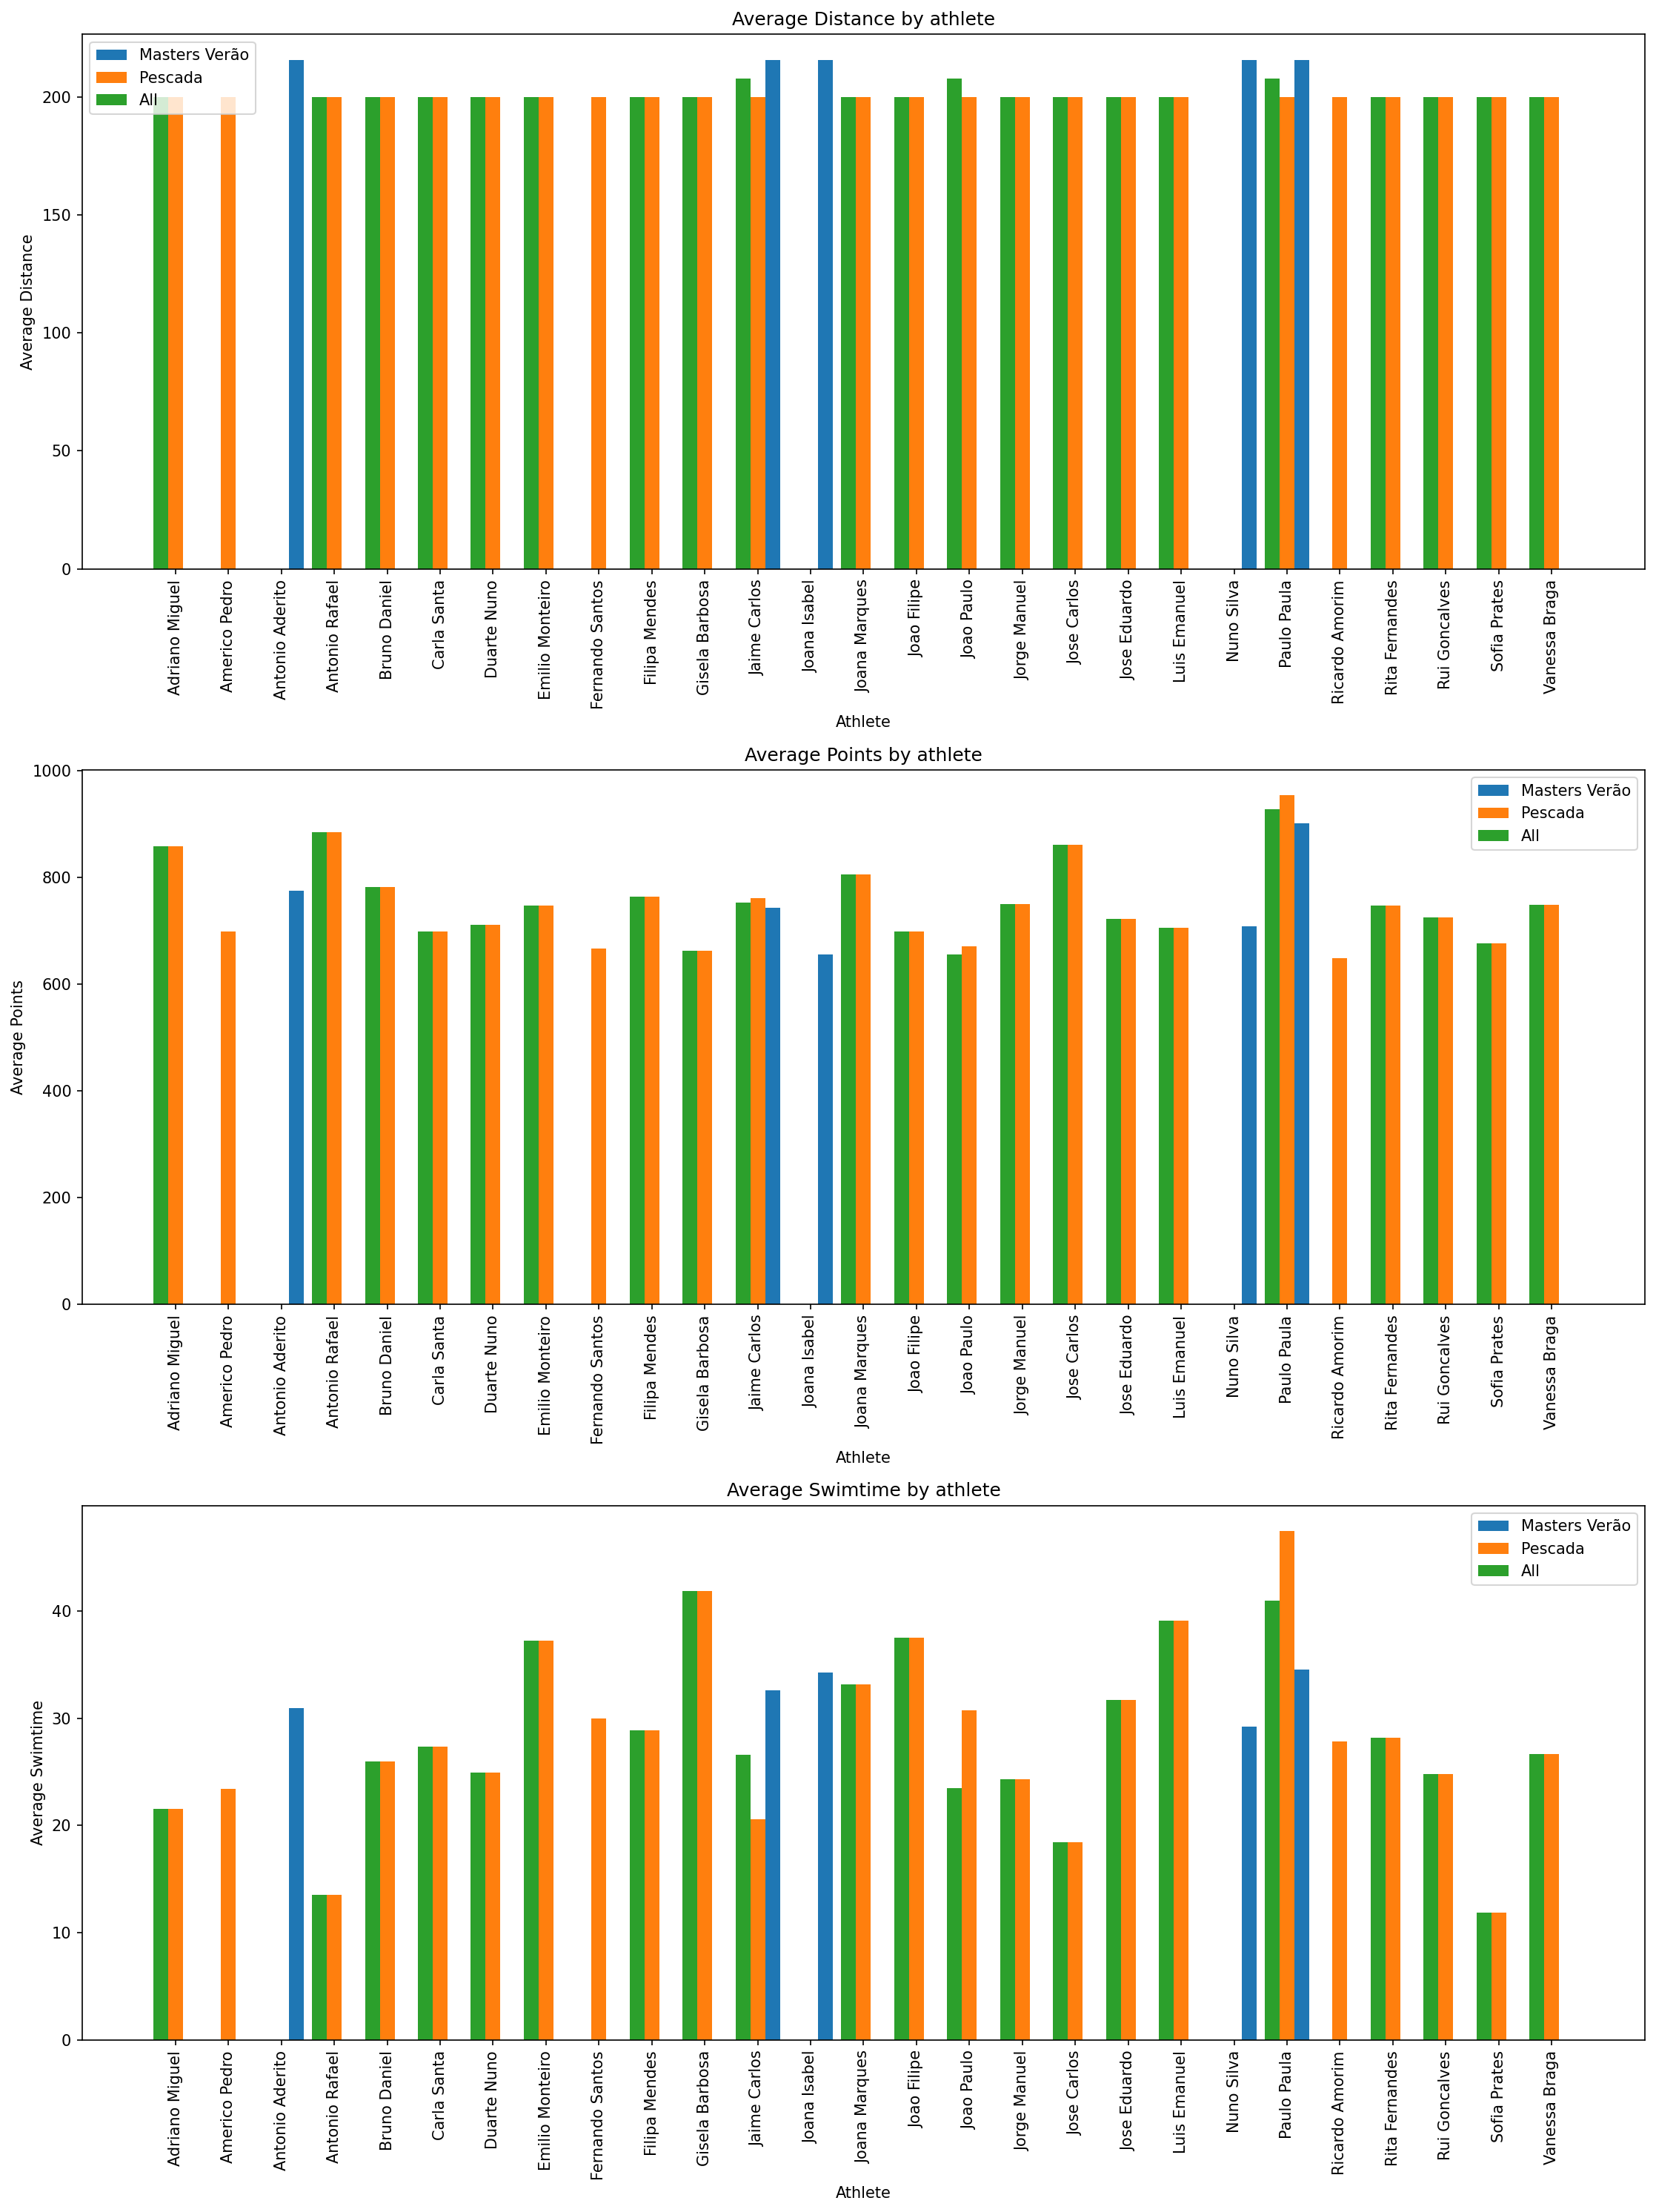

In [52]:
cols = list(df_p.columns.levels[0])
idx = df_p.index
x = np.arange(len(np.array(idx)))
clubs = np.array(df_p.index)


width = 0.28  #the width of the bars

fig, ax = plt.subplots(len(cols), figsize=(15,20), dpi=150)
ax.ravel()

for i in range(len(cols)):
    col = cols[i]

    col_1 = df_p[cols[i]].reset_index().iloc[:, 1].values
    col_2 = df_p[cols[i]].reset_index().iloc[:, 2].values
    col_3 = df_p[cols[i]].reset_index().iloc[:, 3].values

    ax[i].bar(x + width , col_1, width, label='Masters Verão')
    ax[i].bar(x, col_2, width, label='Pescada')
    ax[i].bar(x - width, col_3, width, label='All')

    ax[i].set_xticks(x, clubs, rotation=90)
    
    ax[i].set_xlabel('Athlete')
    ax[i].set_ylabel("{colname}".format(colname=col))
    ax[i].set_title("{colname} by athlete".format(colname=col))
    ax[i].legend()
plt.tight_layout()
plt.savefig('athletefact.pdf')
plt.show()

